# Mortgage Interest Rate Comparison Analysis

This notebook compares a fixed mortgage rate vs. variable rate scenarios to determine the breakeven point.

## Loan Details

- **Total Price**: 2,695,000 SEK
- **Down Payment**: 404,000 SEK
- **Loan Amount**: 2,291,000 SEK
- **Amortization Rate**: 2.0% per year (Swedish requirement)
- **Fixed Rate Option**: 2.57% (locked for 3 years)
- **Variable Rate Starting**: 2.35%

This analysis compares multiple interest rate scenarios to determine which option provides the best value.

## Setup

In [61]:
# Install required packages
!pip install numpy pandas matplotlib seaborn -q

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

## Define Loan Parameters

In [62]:
# Loan details
total_price = 2_695_000
down_payment = 404_000
loan_amount = total_price - down_payment
amortization_rate = 2.0  # 2% per year

# Rate options
fixed_rate = 2.57
variable_rate_start = 2.35

# Time periods
total_months = 36  # 3 years

print(f"Loan Amount: {loan_amount:,.0f} SEK")
print(f"Amortization Rate: {amortization_rate}% per year")
print(f"Fixed Interest Rate: {fixed_rate}% (all 3 years)")
print(f"Variable Rate Starting: {variable_rate_start}%")
print(f"Analysis Period: {total_months} months")


Loan Amount: 2,291,000 SEK
Amortization Rate: 2.0% per year
Fixed Interest Rate: 2.57% (all 3 years)
Variable Rate Starting: 2.35%
Analysis Period: 36 months


## Define Scenarios

All variable rate scenarios use mid-year step changes (rate adjustments twice per year) to model realistic central bank behavior.

In [63]:
def create_midyear_step_schedule(y0_end, y1_end, y2_end, y3_end):
    """
    Create a step rate progression schedule with changes at mid-year.
    More realistic representation of how central banks change rates.
    
    Args:
        y0_end: End of year 0 (starting rate, month 0)
        y1_end: End of year 1 (month 12)
        y2_end: End of year 2 (month 24)
        y3_end: End of year 3 (month 36)
    
    Returns:
        List of 36 monthly rates with mid-year step changes
    """
    rates = []
    
    # Year 1: months 1-6 stay at y0_end, months 7-12 step to mid-point
    mid_y0_y1 = (y0_end + y1_end) / 2
    for i in range(1, 7):
        rates.append(y0_end)
    for i in range(7, 13):
        rates.append(mid_y0_y1)
    
    # Year 2: months 13-18 stay at y1_end, months 19-24 step to mid-point
    mid_y1_y2 = (y1_end + y2_end) / 2
    for i in range(13, 19):
        rates.append(y1_end)
    for i in range(19, 25):
        rates.append(mid_y1_y2)
    
    # Year 3: months 25-30 stay at y2_end, months 31-36 step to y3_end
    mid_y2_y3 = (y2_end + y3_end) / 2
    for i in range(25, 31):
        rates.append(y2_end)
    for i in range(31, 37):
        rates.append(mid_y2_y3)
    
    return rates

# Bank baseline forecast
baseline_bank = (2.35, 2.50, 2.80, 2.95)

# Calculate statistical variations around bank baseline
# Using ±0.15% (1 std dev) and ±0.30% (2 std dev) for confidence intervals
std_dev_1 = 0.15
std_dev_2 = 0.30

scenario_definitions = {
    # === BANK-BASED SCENARIOS ===
    'Baseline': baseline_bank,
    'Bank + Stabilize': (2.35, 2.50, 2.80, 2.80),
    'Bank + Spike': (2.35, 2.50, 2.80, 3.30),
    
    # === BANK STATISTICAL VARIATIONS (68% confidence: ±1σ) ===
    'Bank +1σ (Y1)': (2.35, 2.50 + std_dev_1, 2.80, 2.95),
    'Bank -1σ (Y1)': (2.35, 2.50 - std_dev_1, 2.80, 2.95),
    'Bank +1σ (Y2)': (2.35, 2.50, 2.80 + std_dev_1, 2.95),
    'Bank -1σ (Y2)': (2.35, 2.50, 2.80 - std_dev_1, 2.95),
    'Bank +1σ (Y3)': (2.35, 2.50, 2.80, 2.95 + std_dev_1),
    'Bank -1σ (Y3)': (2.35, 2.50, 2.80, 2.95 - std_dev_1),
    
    # === BANK STATISTICAL VARIATIONS (95% confidence: ±2σ) ===
    'Bank +2σ (Y3)': (2.35, 2.50, 2.80, 2.95 + std_dev_2),
    'Bank -2σ (Y3)': (2.35, 2.50, 2.80, 2.95 - std_dev_2),
    'Bank +2σ (Progressive)': (2.35, 2.50 + std_dev_1, 2.80 + std_dev_2, 2.95 + std_dev_2),
    'Bank -2σ (Progressive)': (2.35, 2.50 - std_dev_1, 2.80 - std_dev_2, 2.95 - std_dev_2),
    
    # === ALTERNATIVE SCENARIOS ===
    'Aggressive Hikes': (2.35, 2.75, 3.25, 3.75),
    'Early Peak + Drop': (2.35, 2.65, 2.95, 2.75),
    'Gradual Rise': (2.35, 2.45, 2.60, 2.75),
    'Rate Cuts': (2.35, 2.40, 2.25, 2.05),
    'Volatility': (2.35, 2.55, 2.45, 2.85),
    'Stagnation': (2.35, 2.40, 2.50, 2.55),
    'Break-Even Path': (2.35, 2.35, 2.57, 3.00),
    'Max Optimistic': (2.35, 2.35, 2.35, 2.35),
    'Max Pessimistic': (2.35, 2.75, 3.35, 4.10),
    
    # === ADDITIONAL RISK SCENARIOS ===
    'Late Spike': (2.35, 2.40, 2.50, 3.50),
    'Double Peak': (2.35, 2.85, 2.45, 2.95),
    'Steady Moderate': (2.35, 2.50, 2.65, 2.75),
    'Immediate Hike + Hold': (2.35, 3.00, 3.00, 3.00),
    'Deflation Scenario': (2.35, 2.20, 2.00, 1.75),
    'Bank Forecast Pessimistic': (2.35, 2.50, 2.80, 3.10),
    
    # === VARIATIONS (±0.10% on Year 3) ===
    'Baseline (High)': (2.35, 2.50, 2.80, 3.05),
    'Baseline (Low)': (2.35, 2.50, 2.80, 2.85),
    'Aggressive Hikes (High)': (2.35, 2.75, 3.25, 3.85),
    'Aggressive Hikes (Low)': (2.35, 2.75, 3.25, 3.65),
    'Gradual Rise (High)': (2.35, 2.45, 2.60, 2.85),
    'Gradual Rise (Low)': (2.35, 2.45, 2.60, 2.65),
    'Rate Cuts (High)': (2.35, 2.40, 2.25, 2.15),
    'Rate Cuts (Low)': (2.35, 2.40, 2.25, 1.95),
}

# Create all scenarios
scenarios = {
    'Fixed Rate (2.57%)': [fixed_rate] * total_months,
}

# All variable rate scenarios use mid-year step function (more realistic)
for name, (y0, y1, y2, y3) in scenario_definitions.items():
    scenarios[name] = create_midyear_step_schedule(y0, y1, y2, y3)

# Create DataFrame
df_rates = pd.DataFrame(scenarios)
df_rates.index = range(1, total_months + 1)
df_rates.index.name = 'Month'

# Print summary
print("=" * 80)
print("SCENARIO OVERVIEW")
print("=" * 80)
print(f"\nFixed Rate: {fixed_rate}% (constant for all 36 months)")
print(f"Variable Rate Starting: {variable_rate_start}%")
print("\n" + "=" * 80)
print("Year-End Rates by Scenario:")
print("=" * 80)
print(f"{'Scenario':<30s} {'Y1 End':>8s} {'Y2 End':>8s} {'Y3 End':>8s}")
print("-" * 80)
for name, (y0, y1, y2, y3) in scenario_definitions.items():
    print(f"{name:<30s} {y1:>7.2f}% {y2:>7.2f}% {y3:>7.2f}%")
print("=" * 80)

SCENARIO OVERVIEW

Fixed Rate: 2.57% (constant for all 36 months)
Variable Rate Starting: 2.35%

Year-End Rates by Scenario:
Scenario                         Y1 End   Y2 End   Y3 End
--------------------------------------------------------------------------------
Baseline                          2.50%    2.80%    2.95%
Bank + Stabilize                  2.50%    2.80%    2.80%
Bank + Spike                      2.50%    2.80%    3.30%
Bank +1σ (Y1)                     2.65%    2.80%    2.95%
Bank -1σ (Y1)                     2.35%    2.80%    2.95%
Bank +1σ (Y2)                     2.50%    2.95%    2.95%
Bank -1σ (Y2)                     2.50%    2.65%    2.95%
Bank +1σ (Y3)                     2.50%    2.80%    3.10%
Bank -1σ (Y3)                     2.50%    2.80%    2.80%
Bank +2σ (Y3)                     2.50%    2.80%    3.25%
Bank -2σ (Y3)                     2.50%    2.80%    2.65%
Bank +2σ (Progressive)            2.65%    3.10%    3.25%
Bank -2σ (Progressive)            2.35% 

## Analysis

### Interest Rate Scenarios

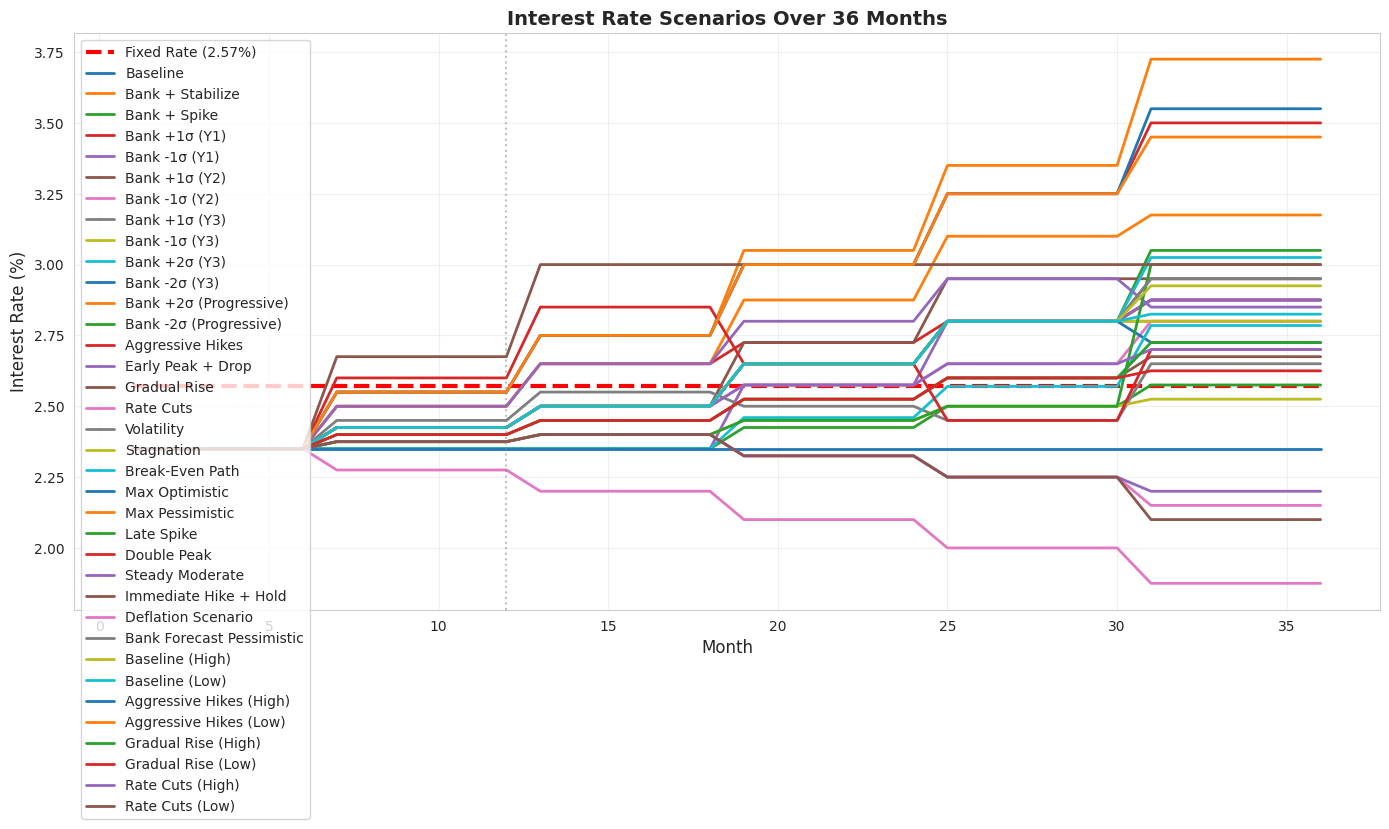

In [64]:
plt.figure(figsize=(14, 8))

# Plot each scenario
for column in df_rates.columns:
    if 'Fixed' in column:
        plt.plot(df_rates.index, df_rates[column], 
                label=column, linewidth=3, linestyle='--', color='red')
    else:
        plt.plot(df_rates.index, df_rates[column], label=column, linewidth=2)

plt.xlabel('Month', fontsize=12)
plt.ylabel('Interest Rate (%)', fontsize=12)
plt.title('Interest Rate Scenarios Over 36 Months', fontsize=14, fontweight='bold')
plt.legend(loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.axvline(x=12, color='gray', linestyle=':', alpha=0.5, label='End of Steady Period')
plt.tight_layout()
plt.show()

### Monthly Costs

In [65]:
def calculate_monthly_interest(loan_amount, annual_rate_percent):
    """
    Calculate monthly interest cost (interest-only, no amortization)
    """
    monthly_rate = annual_rate_percent / 100 / 12
    return loan_amount * monthly_rate

def calculate_monthly_amortization(loan_amount, annual_amortization_percent):
    """
    Calculate monthly amortization payment
    """
    annual_amortization = loan_amount * (annual_amortization_percent / 100)
    return annual_amortization / 12

def calculate_total_monthly_cost(loan_amount, annual_rate_percent, annual_amortization_percent):
    """
    Calculate total monthly cost including both interest and amortization
    """
    interest = calculate_monthly_interest(loan_amount, annual_rate_percent)
    amortization = calculate_monthly_amortization(loan_amount, annual_amortization_percent)
    return interest + amortization

# Calculate monthly costs for each scenario
df_monthly_costs = pd.DataFrame()
df_monthly_interest = pd.DataFrame()
df_monthly_amortization = pd.DataFrame()

# Monthly amortization is constant
monthly_amortization = calculate_monthly_amortization(loan_amount, amortization_rate)

for column in df_rates.columns:
    df_monthly_interest[column] = df_rates[column].apply(
        lambda rate: calculate_monthly_interest(loan_amount, rate)
    )
    # Total cost = Interest + Amortization
    df_monthly_costs[column] = df_monthly_interest[column] + monthly_amortization

### Monthly Payment Visualization

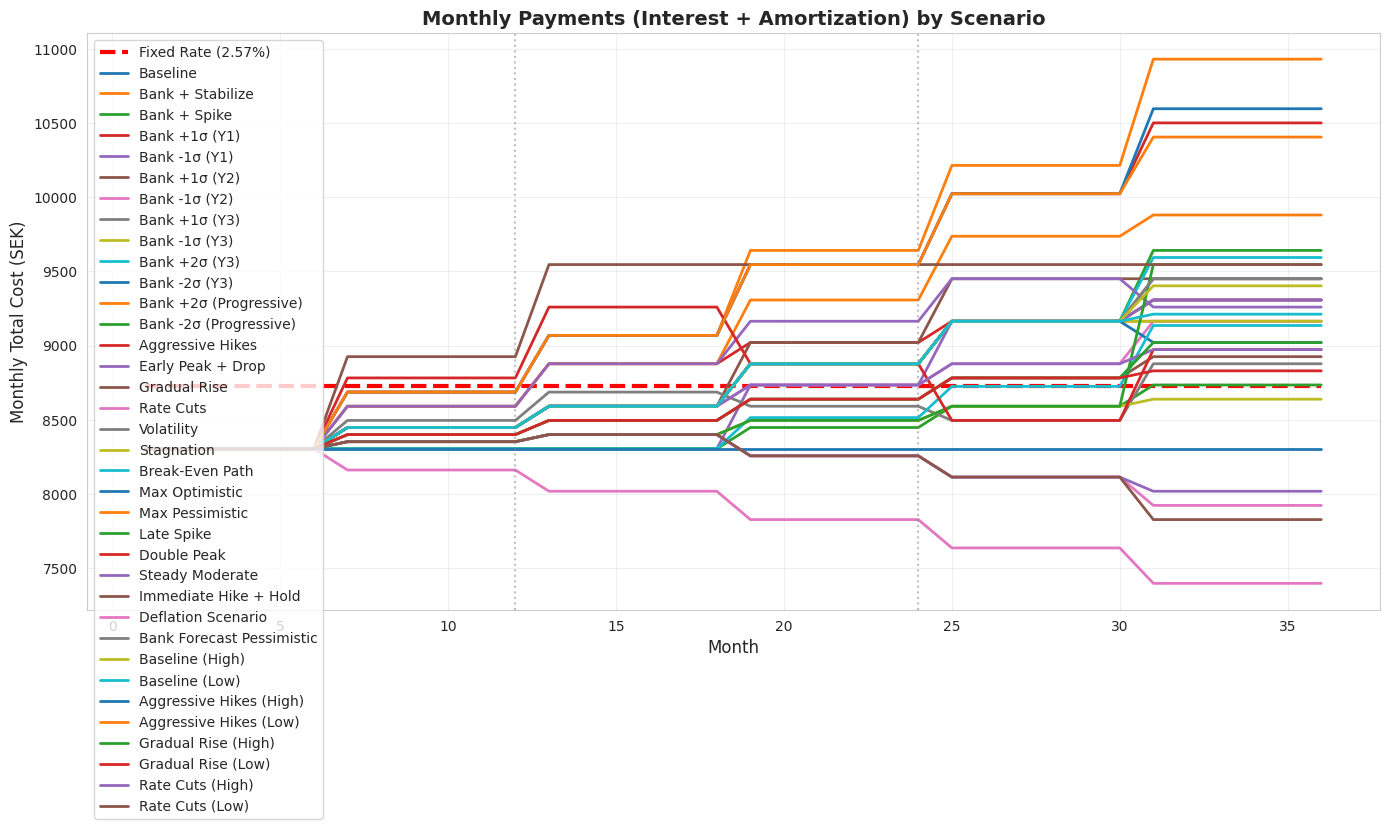

In [66]:
plt.figure(figsize=(14, 8))

for column in df_monthly_costs.columns:
    if 'Fixed' in column:
        plt.plot(df_monthly_costs.index, df_monthly_costs[column], 
                label=column, linewidth=3, linestyle='--', color='red')
    else:
        plt.plot(df_monthly_costs.index, df_monthly_costs[column], 
                label=column, linewidth=2)

plt.xlabel('Month', fontsize=12)
plt.ylabel('Monthly Total Cost (SEK)', fontsize=12)
plt.title('Monthly Payments (Interest + Amortization) by Scenario', fontsize=14, fontweight='bold')
plt.legend(loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.axvline(x=12, color='gray', linestyle=':', alpha=0.5)
plt.axvline(x=24, color='gray', linestyle=':', alpha=0.5)
plt.tight_layout()
plt.show()

### Cumulative Savings vs Fixed Rate

In [67]:
# Calculate cumulative costs
df_cumulative = df_monthly_costs.cumsum()

# Calculate cumulative savings vs. fixed rate
df_savings = pd.DataFrame()
fixed_cumulative = df_cumulative['Fixed Rate (2.57%)']

for column in df_cumulative.columns:
    if column != 'Fixed Rate (2.57%)':  # All columns except the fixed rate
        df_savings[column] = fixed_cumulative - df_cumulative[column]

#### All Scenarios

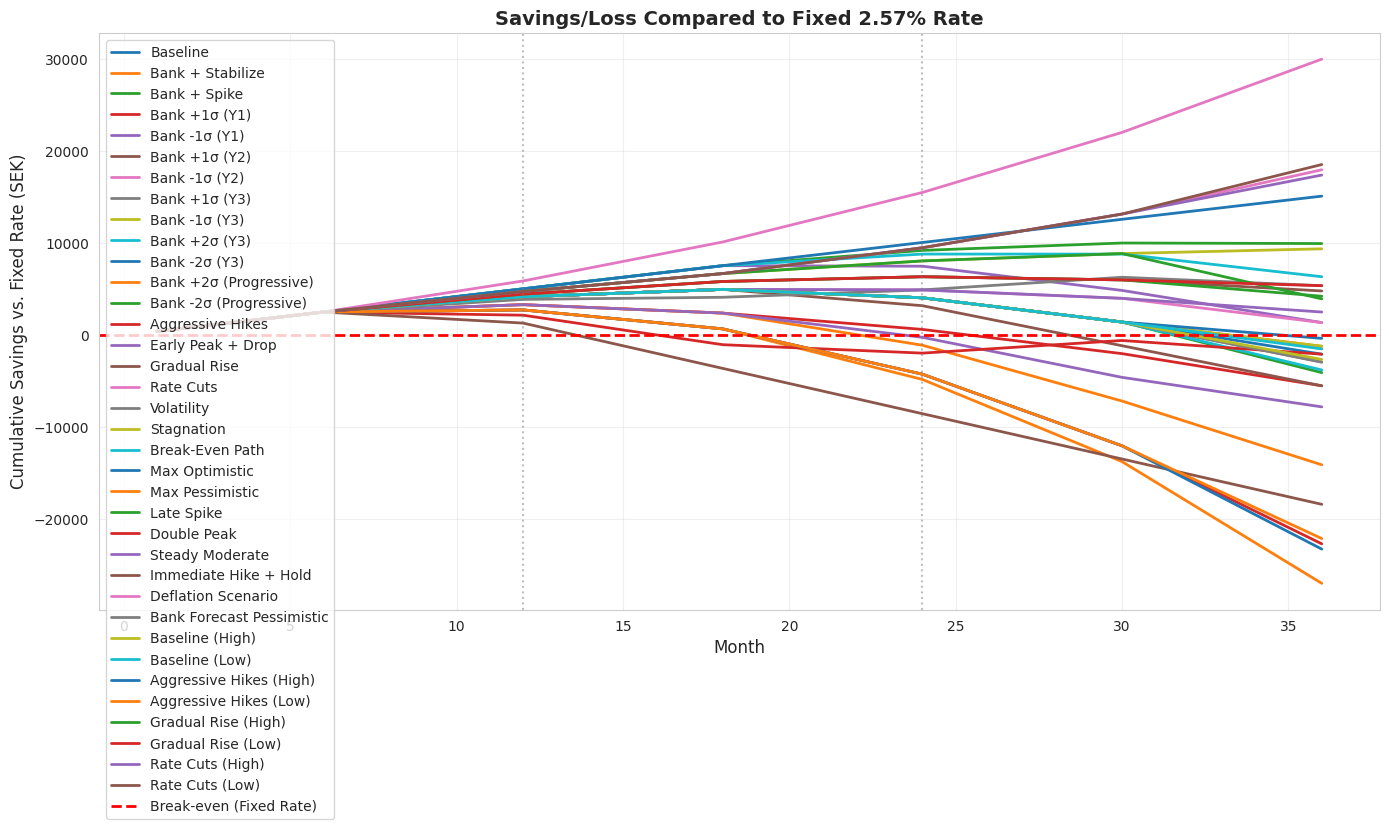

In [68]:
plt.figure(figsize=(14, 8))

for column in df_savings.columns:
    plt.plot(df_savings.index, df_savings[column], label=column, linewidth=2)

plt.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Break-even (Fixed Rate)')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Cumulative Savings vs. Fixed Rate (SEK)', fontsize=12)
plt.title('Savings/Loss Compared to Fixed 2.57% Rate', fontsize=14, fontweight='bold')
plt.legend(loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.axvline(x=12, color='gray', linestyle=':', alpha=0.5)
plt.axvline(x=24, color='gray', linestyle=':', alpha=0.5)
plt.fill_between(df_savings.index, 0, 0, alpha=0.2)
plt.tight_layout()
plt.show()

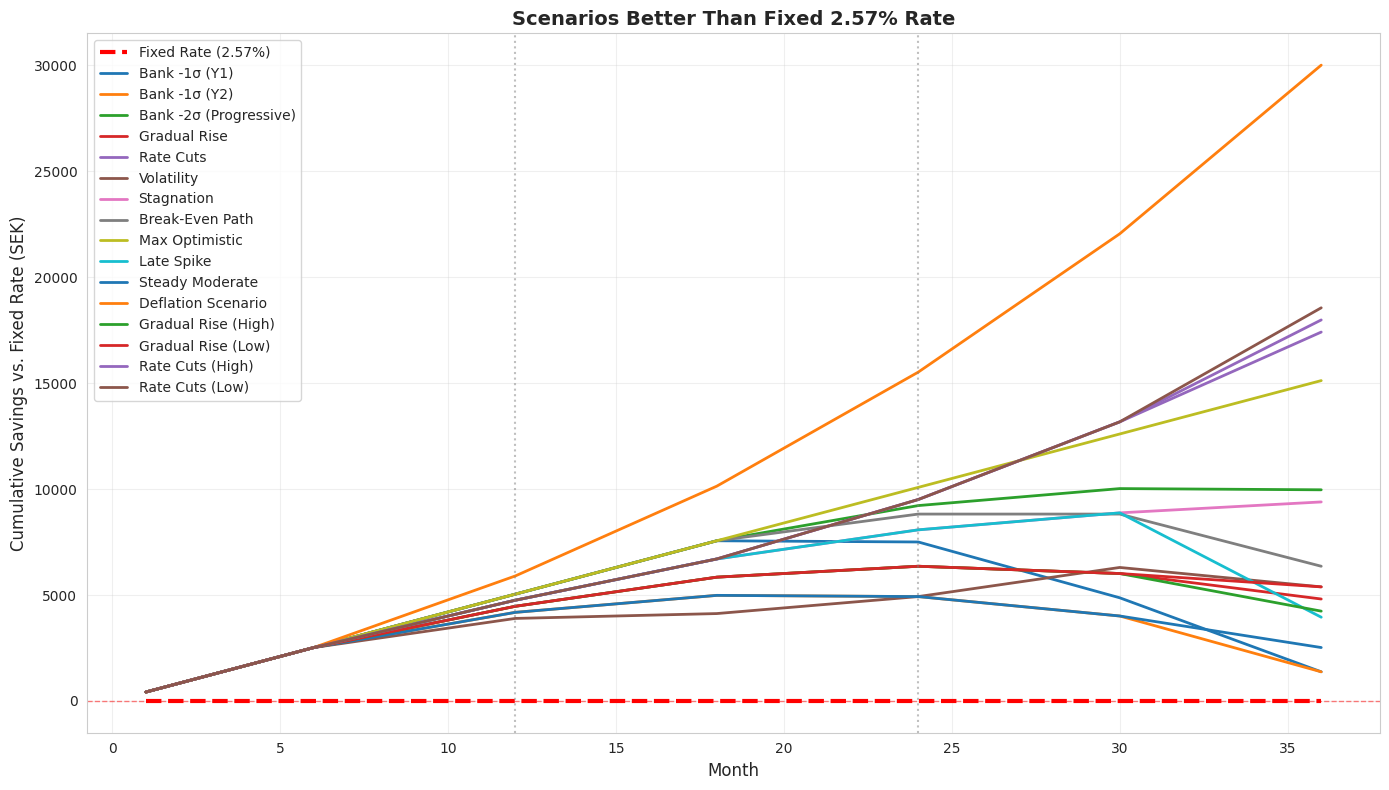


Total scenarios better than fixed rate: 16


In [69]:
# Filter scenarios that are better than fixed (positive savings)
better_scenarios = []
for column in df_savings.columns:
    if df_savings[column].iloc[-1] > 0:
        better_scenarios.append(column)

if better_scenarios:
    plt.figure(figsize=(14, 8))
    
    # Plot fixed rate as reference
    plt.plot(df_savings.index, [0] * len(df_savings.index), 
             label='Fixed Rate (2.57%)', linewidth=3, linestyle='--', color='red')
    
    # Plot only scenarios better than fixed
    for column in better_scenarios:
        plt.plot(df_savings.index, df_savings[column], label=column, linewidth=2)
    
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Cumulative Savings vs. Fixed Rate (SEK)', fontsize=12)
    plt.title('Scenarios Better Than Fixed 2.57% Rate', fontsize=14, fontweight='bold')
    plt.legend(loc='upper left', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
    plt.axvline(x=12, color='gray', linestyle=':', alpha=0.5)
    plt.axvline(x=24, color='gray', linestyle=':', alpha=0.5)
    plt.tight_layout()
    plt.show()
    
    print(f"\nTotal scenarios better than fixed rate: {len(better_scenarios)}")
else:
    print("No scenarios are better than the fixed rate over the 36-month period.")

#### Scenarios Worse Than Fixed Rate

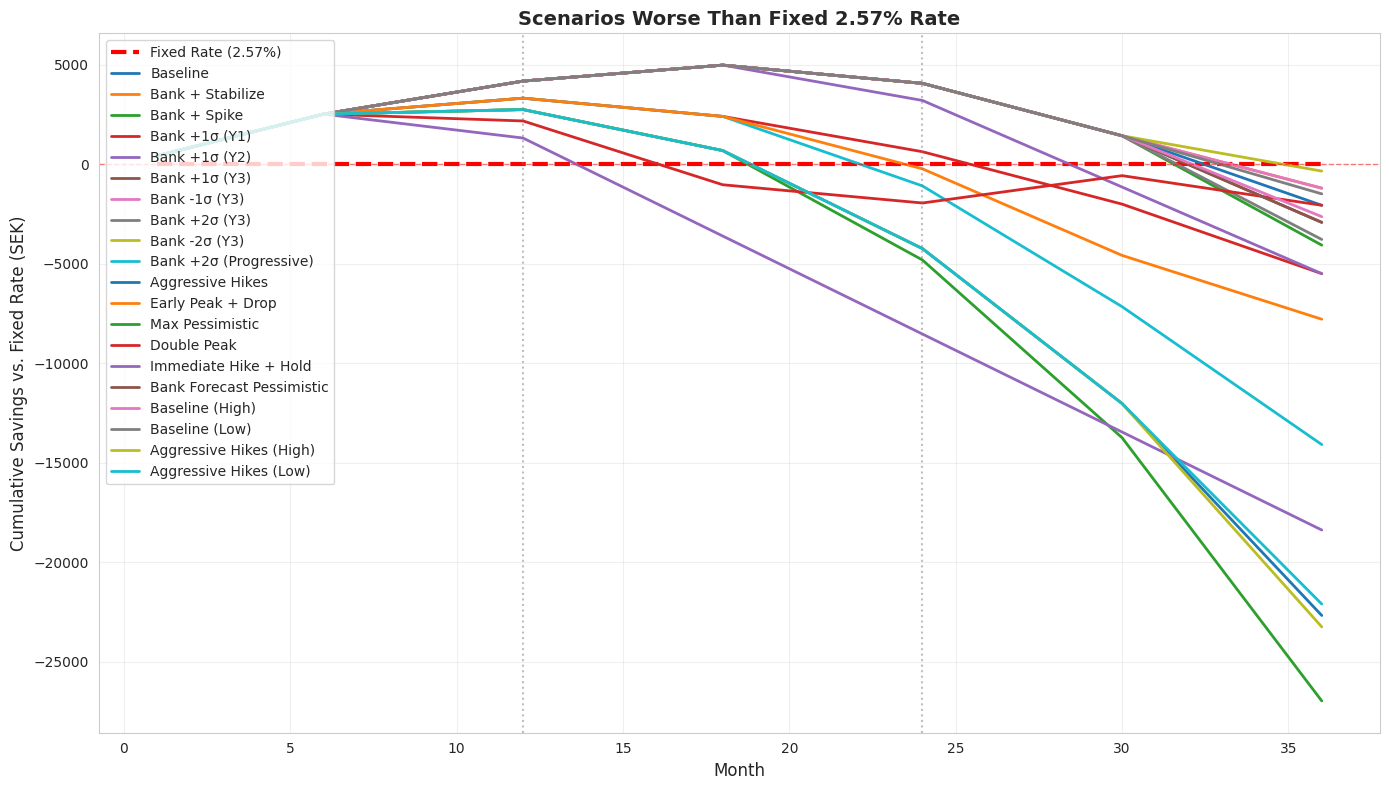


Total scenarios worse than fixed rate: 20


In [70]:
# Filter scenarios that are worse than fixed (negative savings)
worse_scenarios = []
for column in df_savings.columns:
    if df_savings[column].iloc[-1] <= 0:
        worse_scenarios.append(column)

if worse_scenarios:
    plt.figure(figsize=(14, 8))
    
    # Plot fixed rate as reference
    plt.plot(df_savings.index, [0] * len(df_savings.index), 
             label='Fixed Rate (2.57%)', linewidth=3, linestyle='--', color='red')
    
    # Plot only scenarios worse than fixed
    for column in worse_scenarios:
        plt.plot(df_savings.index, df_savings[column], label=column, linewidth=2)
    
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Cumulative Savings vs. Fixed Rate (SEK)', fontsize=12)
    plt.title('Scenarios Worse Than Fixed 2.57% Rate', fontsize=14, fontweight='bold')
    plt.legend(loc='upper left', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
    plt.axvline(x=12, color='gray', linestyle=':', alpha=0.5)
    plt.axvline(x=24, color='gray', linestyle=':', alpha=0.5)
    plt.tight_layout()
    plt.show()
    
    print(f"\nTotal scenarios worse than fixed rate: {len(worse_scenarios)}")
else:
    print("All scenarios are better than the fixed rate over the 36-month period.")

## Results

Summary tables comparing all scenarios.

In [71]:
# Create summary table
summary_data = []

for column in df_rates.columns:
    total_cost = df_cumulative[column].iloc[-1]
    avg_rate = df_rates[column].mean()
    max_rate = df_rates[column].max()
    
    if column == 'Fixed Rate (2.57%)':
        savings = 0
        comparison = '-'
        rate_progression = f'{fixed_rate}% (constant)'
    else:
        savings = df_savings[column].iloc[-1]
        # Determine if better or worse than fixed
        if avg_rate > fixed_rate:
            comparison = 'Worse'
        else:
            comparison = 'Better'
        
        # Get rate progression from scenario_definitions
        # Extract scenario name without number prefix for matching
        scenario_key = column
        if scenario_key in scenario_definitions:
            y0, y1, y2, y3 = scenario_definitions[scenario_key]
            rate_progression = f'{y1:.2f}%, {y2:.2f}%, {y3:.2f}%'
        else:
            rate_progression = '-'
    
    summary_data.append({
        'Scenario': column,
        'Rate Progression': rate_progression,
        'Avg Rate (%)': round(avg_rate, 2),
        'Max Rate (%)': round(max_rate, 2),
        'Total Interest (SEK)': round(total_cost, 0),
        'vs. Fixed (SEK)': round(savings, 0),
        'vs. Fixed': comparison
    })

df_summary = pd.DataFrame(summary_data)

# Custom print function for left-aligned tables
def print_left_aligned_table(df, title):
    print(f"\n{title}")
    print("=" * 140)
    
    # Print header
    print(f"{'Scenario':<30} {'Rate Progression':<25} {'Avg Rate (%)':<15} {'Max Rate (%)':<15} {'Total Interest (SEK)':<22} {'vs. Fixed (SEK)':<18} {'vs. Fixed':<10}")
    print("-" * 140)
    
    # Print rows
    for _, row in df.iterrows():
        print(f"{str(row['Scenario']):<30} {str(row['Rate Progression']):<25} {str(row['Avg Rate (%)']):<15} {str(row['Max Rate (%)']):<15} {str(int(row['Total Interest (SEK)'])):<22} {str(int(row['vs. Fixed (SEK)'])):<18} {str(row['vs. Fixed']):<10}")

# Print complete summary
print_left_aligned_table(df_summary, "SUMMARY: 36-Month Analysis")

# Print scenarios grouped by performance
better_df = df_summary[df_summary['vs. Fixed'] == 'Better'].sort_values('vs. Fixed (SEK)', ascending=False)
if len(better_df) > 0:
    print_left_aligned_table(better_df, "\nSCENARIOS BETTER THAN FIXED RATE:")
else:
    print("\n" + "=" * 140)
    print("SCENARIOS BETTER THAN FIXED RATE:")
    print("=" * 140)
    print("None")

worse_df = df_summary[df_summary['vs. Fixed'] == 'Worse'].sort_values('vs. Fixed (SEK)')
if len(worse_df) > 0:
    print_left_aligned_table(worse_df, "\nSCENARIOS WORSE THAN FIXED RATE:")
else:
    print("\n" + "=" * 140)
    print("SCENARIOS WORSE THAN FIXED RATE:")
    print("=" * 140)
    print("None")

fixed_df = df_summary[df_summary['Scenario'] == 'Fixed Rate (2.57%)']
print_left_aligned_table(fixed_df, "\nFIXED RATE:")


SUMMARY: 36-Month Analysis
Scenario                       Rate Progression          Avg Rate (%)    Max Rate (%)    Total Interest (SEK)   vs. Fixed (SEK)    vs. Fixed 
--------------------------------------------------------------------------------------------------------------------------------------------
Fixed Rate (2.57%)             2.57% (constant)          2.57            2.57            314096                 0                  -         
Baseline                       2.50%, 2.80%, 2.95%       2.6             2.88            316158                 -2062              Worse     
Bank + Stabilize               2.50%, 2.80%, 2.80%       2.59            2.8             315299                 -1203              Worse     
Bank + Spike                   2.50%, 2.80%, 3.30%       2.63            3.05            318163                 -4067              Worse     
Bank +1σ (Y1)                  2.65%, 2.80%, 2.95%       2.65            2.88            319594                 -5498    